# An RL application: managing the powergrid

You can try this notebook interactively with (click on the logo): [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/Grid2Op/grid2op/master)


During this session we present an application to reinforcement learning in a "real world" scenario.

This notebook is organized as followed:

In the first section we present the basics of powergrid operations (*ie* what some people are doing 24/7 to ensure the rest of the world has access to as much power as possible). 

In the second section, we will expose how to interact with a powergrid using the openAI gym interface and see how to apply some algorithm to solve these problems.

At the end of this lecture you should be able to implement some (state of the art?) algorithm that manges the powergrid for a few days.

**Disclaimer**: This notebook presents the "powergrid problem" in a very simplified version. This "powergrid problem" (as modelized for the l2rpn competitions [Robustness](https://competitions.codalab.org/competitions/25426) and [Adaptability](https://competitions.codalab.org/competitions/25427)) is itself only a small part of what powergrid operators need to do in real time. This notebook does not pretend at all to be exhaustive in the description of all of these problematics.


This notebook is structured as followed:

1. [Problem statement](#Problem-statement)
  1. [1) Introduction to powergrid](#1\)-Introduction-to-powergrid)
  2. [2) Definition of the reward](#2\)-Definition-of-the-reward)
    1. [The joule's effect and the sag](#The-joule's-effect-and-the-sag)
    2. [Thermal limits and protections](#Thermal-limits-and-protections)
    3. [Margin on a powerline](#Margin-on-a-powerline)
  3. [3) Game over](#3\)-Game-over)
    1. [Game over conditions](#Game-over-conditions)
    2. [Operate in safety](#Operate-in-safety)
  4. [4) Action space](#4\)-Action-space)
    1. [Modifying the status of the powerlines](#Modifying-the-status-of-the-powerlines)
    2. [Redispatching](#Redispatching)
       1. [first constraints: P = C + losses => sum(redispatch) = 0](#first-constraints:-P-=-C-+-losses-=>-sum\(redispatch\)-=-0)
       2. [second contraints: ramps => actual dispatch != target dispatch](#second-contraints:-ramps-=>-actual-dispatch-!=-target-dispatch)
       3. [third constraints: the pmin / pmax](#third-constraints:-the-pmin-/-pmax)
  5. [5) Wrapping up](#5\)-Wrapping-up)
  6. [6) Optional: diving deeper into grid2op](#6\)-Optional:-diving-deeper-into-grid2op)
    1. [Dataset](#Dataset)
    2. [Specific rules](#Specific-rules)
2. [Creating some agents](#Creating-some-agents)
  1. [1) Compatibility with gym](#1\)-Compatibility-with-gym)
    1. [Convert the environment to gym](#Convert-the-environment-to-gym)
    2. [Convert the observation space to gym](#Convert-the-observation-space-to-gym)
    3. [Convert the action space](#Convert-the-action-space)
  2. [2) Some Baselines](#2\)-Some-Baselines)
    1. [Do nothing "agent"](#Do-nothing-"agent")
    2. [Random Agent and operational constraints](#Random-Agent-and-operational-constraints)
  3. [3) Going further](#3\)-Going-further)
  
  
If you want to get directly to the definition of the problem, you can visit the section [5) Wrapping up](#5\)-Wrapping-up) and if you prefer to dive into the creation of your first agent, then you can switch directly to [Creating some agents](#Creating-some-agents) TODO

## Problem statement


### 1) Introduction to powergrid
For this notebook we will use a dedicated environment called "educ_case14_redisp". Grid2op comes with many different environments, with different problems etc. In this notebook, we will only mention and explain this specific environment.

Power system have one major objective: allow the transmission of electricity from the producers to the consumers as effeciently as possible.

This environment is based on the "IEEE case14" grid studied in the litterature.

This grid counts 20 power lines (represented in the figure bellow by the black line), 11 loads (each one representing a city or a big industrial consumer) represented by the triangles in the figure bellow and 6 different generators.

Then generators are represented by pentagons. In reality, and as modeled by our environments, generators have varying properties depending on their types. In this environment there are 2 solars generators (in dark orange), 1 hydro generator (in dark blue), 1 nuclear generator (in yellow) and one "thermal" generator (you can imagine powered by coal or natural gas) in violet. 

c:\Users\admin\Grid2Op\venv_g2op\lib\site-packages\grid2op\Backend\pandaPowerBackend.py:36: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\admin\Grid2Op\venv_g2op\Scripts\python.exe -m pip install numba

  warnings.warn(
c:\Users\admin\Grid2Op\venv_g2op\lib\site-packages\grid2op\MakeEnv\Make.py:454: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


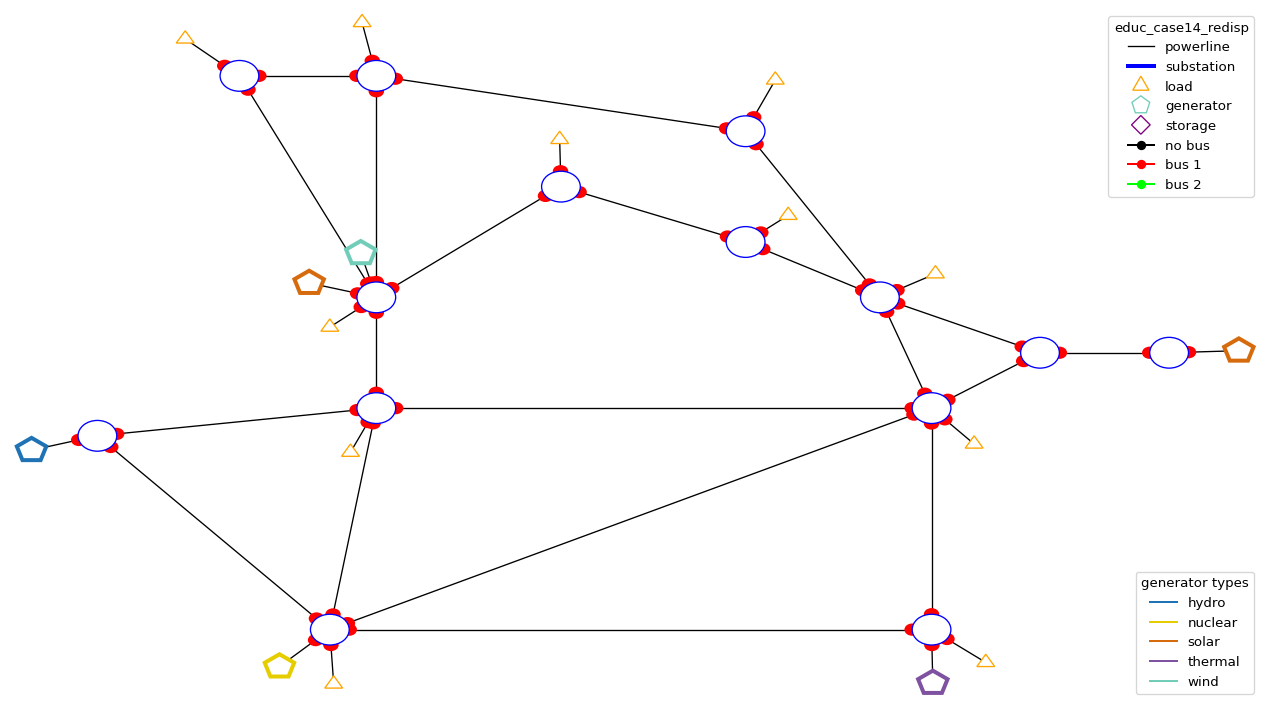

In [1]:
import numpy as np  # 99% of python scripts (for data science) use this package
import grid2op  # main package
from grid2op.PlotGrid import PlotMatplot  # for representing (plotting) the grid
env = grid2op.make("educ_case14_redisp", test=True)  # creating the environment (compatible with openai gym)
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_gen_type()
max_iter = 10  # we put 10 here so that the notebook run entirely in a few seconds. put -1 if you don't want to enforce this limitation.

**GOAL**: The goal of the "game" you will play is the following: given some phyiscal constraints (more on that on the next section) your agent will need to adjust the productions of the dispatchable generators as to minimize the  "margin" of each powerline on the grid.

### 2) Definition of the reward

#### The joule's effect and the sag
In reality, each powerline cannot transmit an infinite amount of power. 

Due to some constraints: for example, when too much current pass on a line, because of the Joule's effect, this powerline heats. And because powerlines are made in metal, when they heat they inflate and so get closer to the ground... or... your house...

This phenomenon is illustrated in the figure below:

The flow is relatively small, the powerline is far above the tree
![title](img/sag0.jpg)

The flow increases, the powerline gets closer to the tree
![title](img/sag1.jpg)

The flow is too high, the powerline gets closer even closer to the tree and ends up touching it
![title](img/sag2.jpg)

Which can, in the best case break the powerline or, depending on the season, the weather, etc. set aflame a whole part of a state (this is the cause of some of the fire in California in 2020) possibly killing dozens of people.


#### Thermal limits and protections

To avoid being in such trouble, companies operating powergrids, often set up some limits on the flows that can be transmitted on the powergrid. For the sake of the example, we displayed the this limit (called thermal limit) on each powerline on the grid in the next cell.

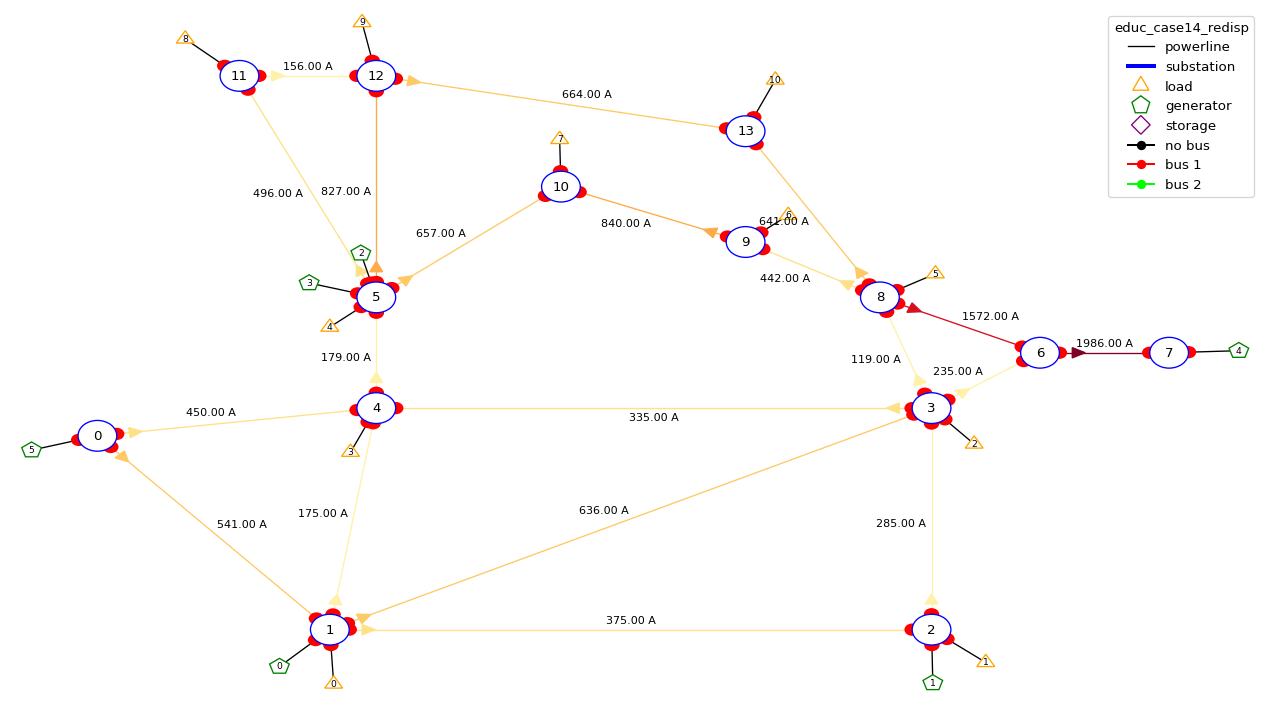

In [2]:
plot_helper.assign_line_palette()  # get a prettier coloring for the powerlines
_ = plot_helper.plot_info(line_values=env.get_thermal_limit(), coloring="line", line_unit="A")
plot_helper.restore_line_palette()

And to be certains that the flows stays below these limits, every powerlines (on our simplified setting) is equiped with some "protections".

The detailed functionning of these protections is out of the scope of this lecture, but the principle is rather simple. A protection is a piece of equipment that will automatically disconnect a powerline if it detects some danger.

For this environment these "protections" will automatically disconnect some powerlines when:

- the flow on the powerline is above the thermal limit for too long (3 consecutive steps)
- the flow on the powerline is exceed twice the thermal limit (in this case the disconnection is instanteneous)

#### Margin on a powerline

Now that we know the current is limited, we can properly define the "margin" on a powerline. The margin can be thought as the amount of current that the powerline can still transmit without any danger.

More formally, if we denote by `i` the current on a given powerline and by `M` its thermal limit then the margin is defined as, for this environment as:
```
relative_flow = i / M
raw_margin = 1 - i / M
raw_margin_capped = max(0., raw_margin)  # to ensure the margin is between 0 and 1
margin_powerline = raw_margin_capped^2
```

The "reward" of this game is then the sum of all the `margin_powerline` for all powerline of the grid. Note that if a powerline is disconnected, with this setting its margin is 1.0 (there is no powerflow on it) and if the powerline is on overflow (the flow `i` is equal or above the thermal limit `M`) the the margin is 0.0, which make sense because in this case, you can't have any more flows on this powerline.


### 3) Game over
So now we have defined what we need to do: at any time we need to maximise the total margin of the grid. This corresponds to taking as less risk as possible during the powergrid operations.


#### Game over conditions
But as we saw, a pretty simple "policy" would solve this problem very easily. As we explained above, when a powerline is disconnected from the grid, then the margin on this powerline is 1.0, which is the highest possible margin. The policy consisting in "disconnecting every powerline" would then be extremely efficient. This makes total sense: if everything is disconnected, the no power is flowing and everything is safe [this is often why I would recommend to switch off the house circuit breaker before trying to touch any powerplug in your house.]

But this solution is not satisfactory. The goal of the powergrid is indeed to bring power to as much people / companies as possible. In our framework grid2op we modeled this phenomenon by introducing some "game over" criteria. And, when the game is over, you lost the game.

To be perfectly exhaustive, there are 4 game over conditions for this environment at the moment:

- a load is disconnected from the grid
- a generator is disconnected from the grid
- the grid is split into independant part
- some technical conditions imposed by the solving of the powerflow equations (out of scope)


#### Operate in safety
So as you see above, the "game over conditions" make the simple policy of disconnecting everything pretty useless. Because, well, it will game over at the first time step.

In this environment, the objective is then to manage different scenarios, each representing a given day and avoid game over.


### 4) Action space
So now, let's dive into the details of what your actions are.

For this envrionment you are allowed to do two different things:

- toggle the status of some powerlines: this means connecting or disconnecting some powerline
- apply redispatching actions: adapt the production of the generators to solve the issues.

In this section we'll detail what are exactly doing these actions, and how to implement them in the grid2op framework.

#### Modifying the status of the powerlines
Powerlines can be switched on / off. We saw a bit earlier that they can be switched off by "protections" in case of overflow (see the section [Thermal limit and protections](#Thermal-limits-and-protections) for more information).

But the agent can also willingly disconnect a powerline and of course, symmetrically, reconnect it.

Let's plot the initial observation of the powergrid:

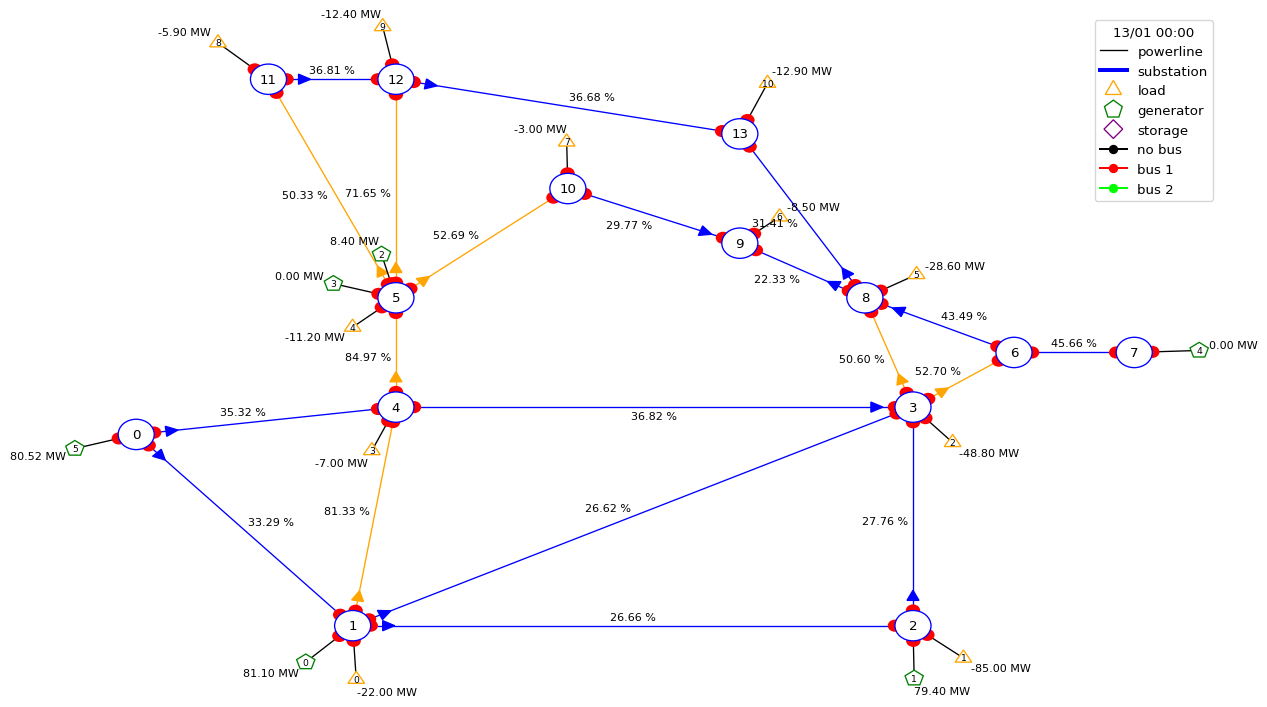

In [3]:
obs = env.reset()
fig_ = plot_helper.plot_obs(obs)

On plot we see different things. 

First, There are some color on some powerlines. This means that the flow on them is less than 50% of the thermal limits. Then we see some powerlines that are orange. 
In this case this means that the flow on them is between 50% and 100% of their thermal limit. If a powerline were to appear red, this would means it's in overflow.
On each powerline, the flows (given by default as a percentage of the thermal limit) is displayed near the powerline.

We also notice some values on the generator: this is the amount of power they are producing, and some values on the load (negative) representing the values they are consuming.

And now let's disconnect the powerline with id `14` and display the resulting state on the screen.

(you can change which line is disconnected by changing the value of the `line_id` variable in the cells bellow)

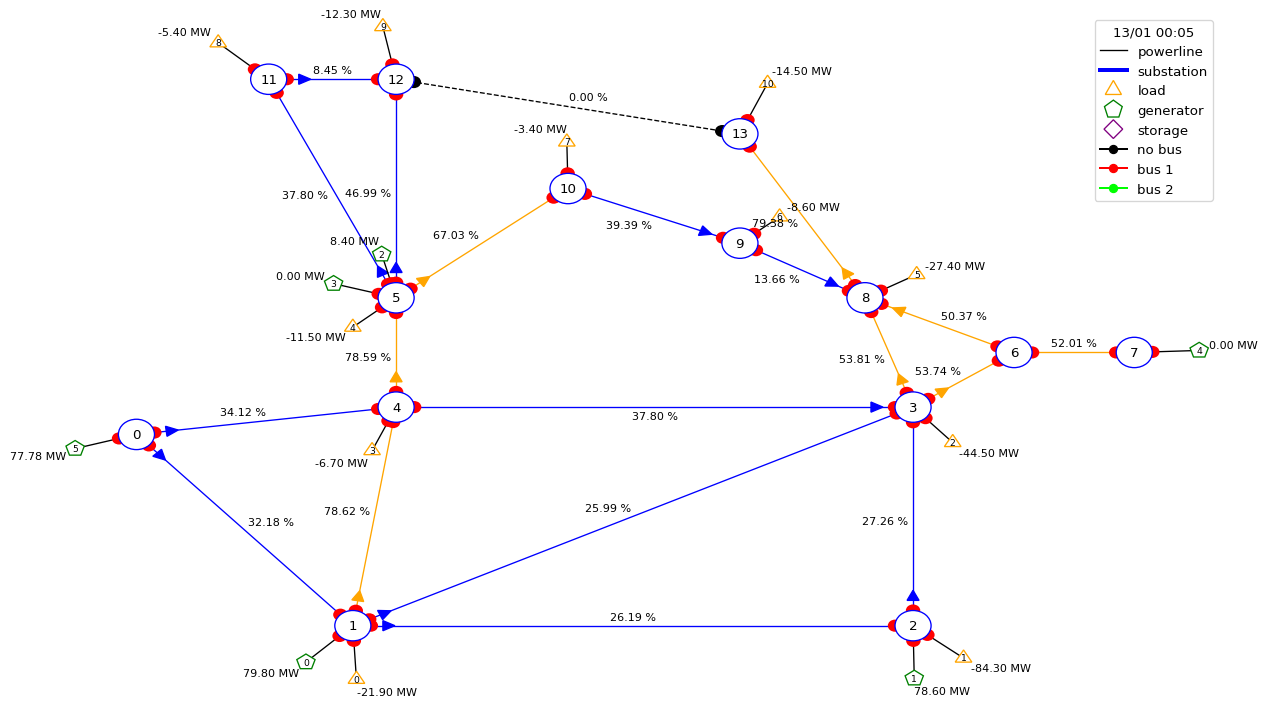

In [4]:
line_id = 14
disco_line = env.action_space({"change_line_status": [line_id]})
new_obs, reward, done, info = env.step(disco_line)
fig_ = plot_helper.plot_obs(new_obs)

On this case we can notice that this powerline (at the top) is now displayed in a dark dashed fashion. This means that it is disconnected.

#### Redispatching
Now that we saw how to disconnect some powerlines, let's see how to perform the other kind of actions available: the redispatching.

##### What is redispatching
But first, what is concretely redispatching? 

Redispatching is the fact to modify the schedule of generators (schedule that was planned usually the day before most of the time either by a central authority or by an economic market). 

This is done in a cumulative manner compared to what the real production should be.

For example if "someone" (a central authority or a market) decided that generator 1 were to produce `77.1`MW at 00:10am and you decided at 00:05am to do a redispatching on this same generator of `+7.0`MW, then, the production of this generator at 00:10am will be `77.1MW [decided the day before by the market or a central authority] + (+7.0MW) [decided by you at 00:05am] = 84.1MW`.

Let's see an example on the cell bellow:

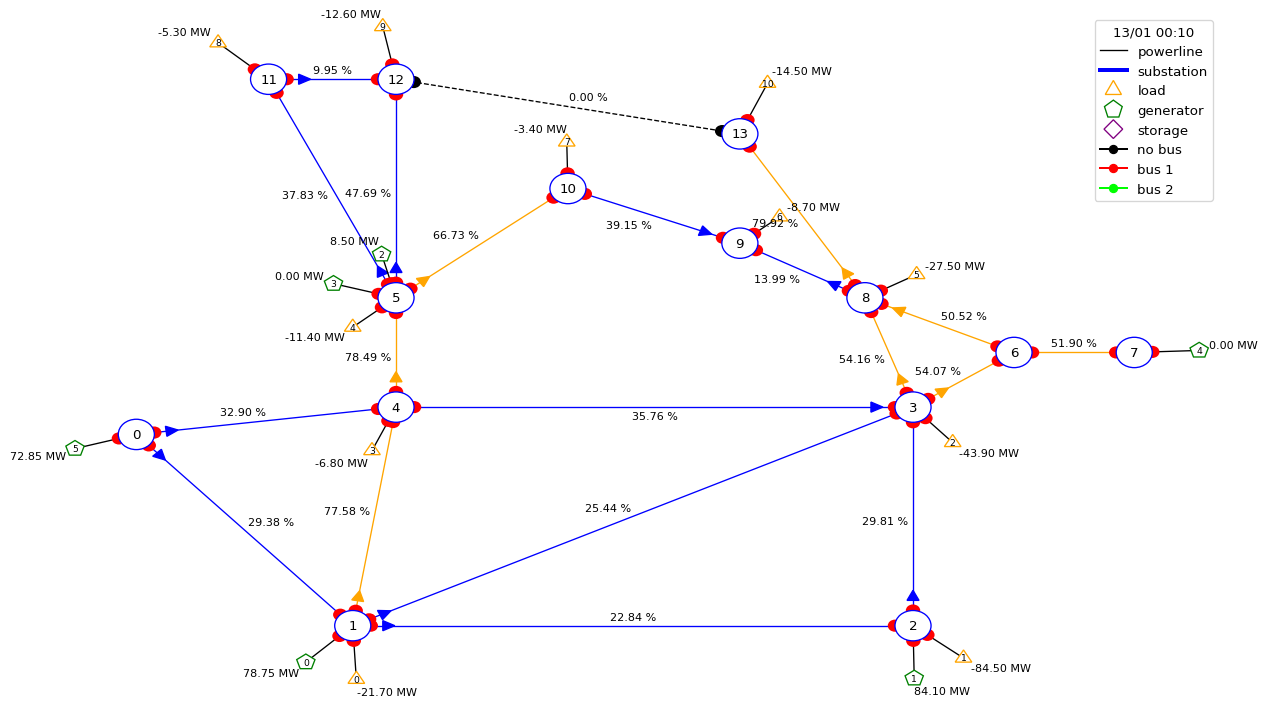

In [5]:
gen_id = 1
dispatch_amount = +7
dispatch_action = env.action_space({"redispatch": [(gen_id, dispatch_amount)]})
new_obs, reward, done, info = env.step(dispatch_action)
fig_ = plot_helper.plot_obs(new_obs)

As you can see here, you still see that the powerline is disconnected (of course no one has reconnected it), but you don't really observe the redispatching on the state. Fortunately, you have a way to plot the redispatching that was made. We'll do it in the next cells

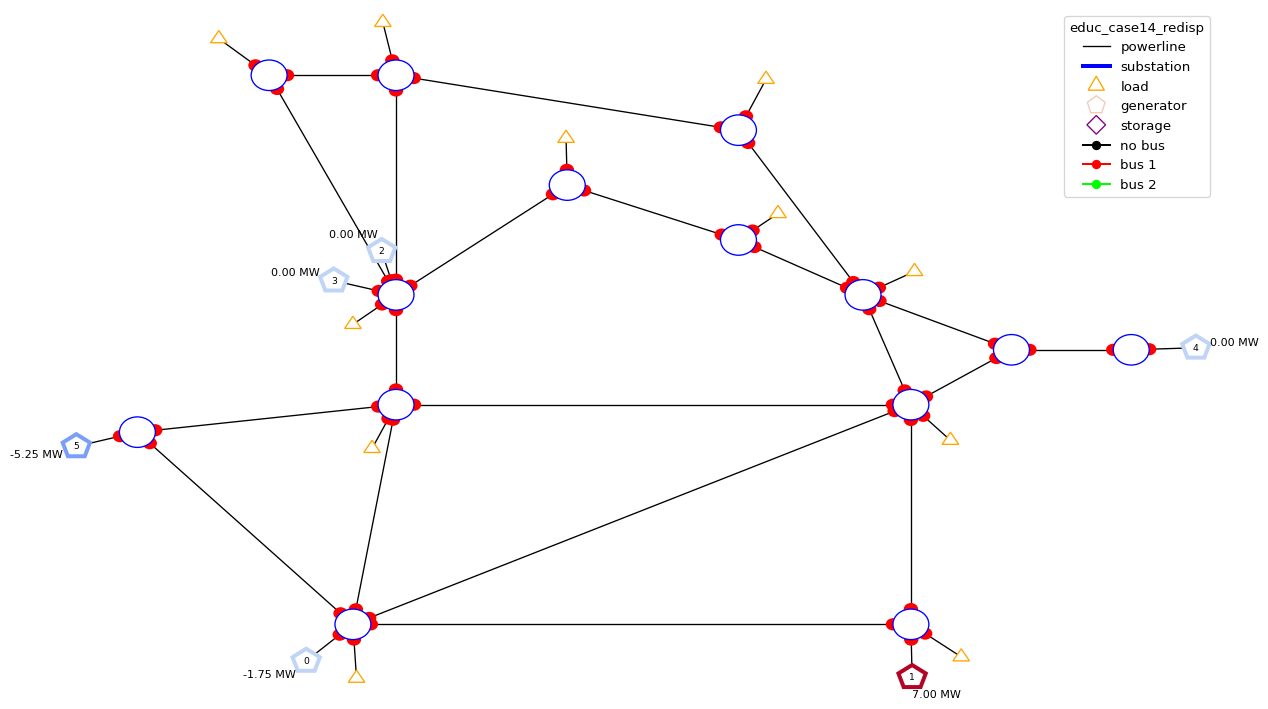

In [6]:
fig_ = plot_helper.plot_current_dispatch(new_obs)

As we can see on the figure above, the generator 1 has seen indeed its production increased by `7`MW (hence the `7.00`MW) but we can see something else.

##### first constraints: P = C + losses => sum(redispatch) = 0
The generators 1 and 5 see their production decreased by `1.75` MW (for generator 0) and `5.25` (for generator 5).

But why is that? This is because a powergrid need to be a steady state. And this implies that the total generation and the total load must be balanced (up to the losses). 

This entails that if you ask to increase a generation somewhere, the environment will have no choice but to decrease the production somewhere else.

Now let's see what happens if I wand to decrease the generator 1 of `10`MW again. So the total "setpoint" for the redispatch on this generator should be `(+7MW) [action previous step] + (+10MW) [action this step] = +17MW`

Let's see what happens if i do that:

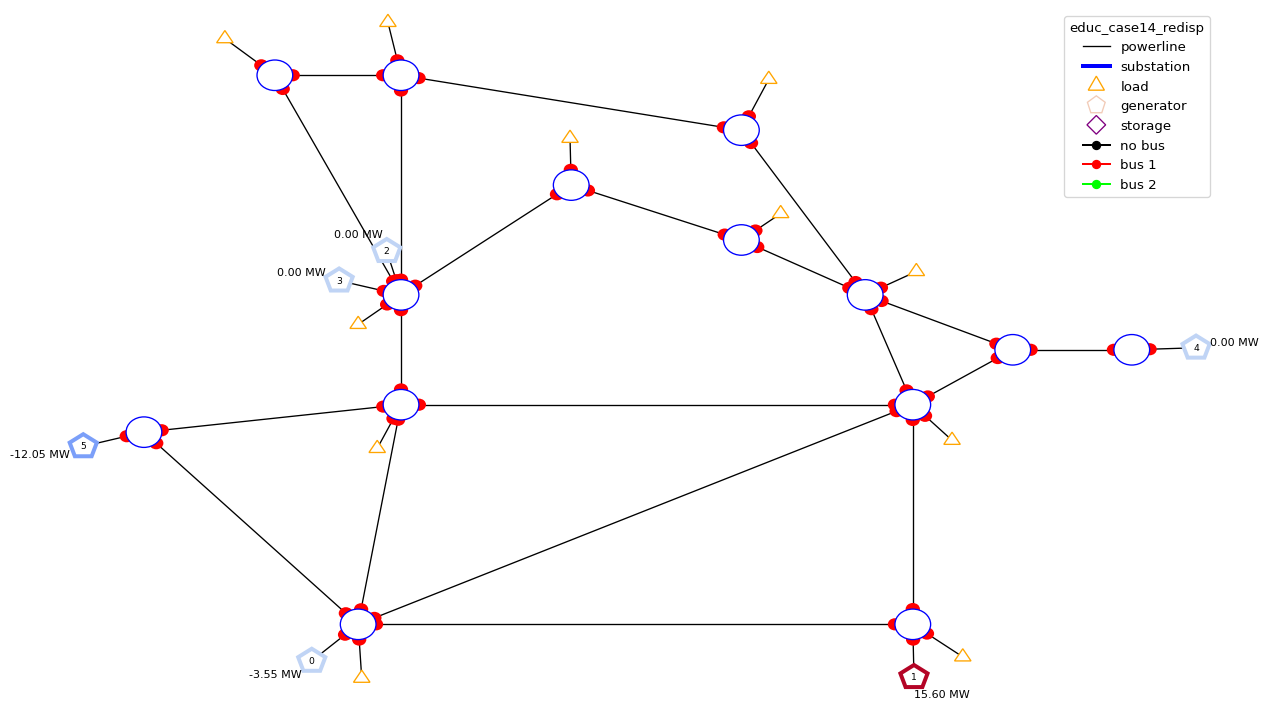

In [7]:
gen_id2 = 1
dispatch_amount2 = +10
dispatch_action2= env.action_space({"redispatch": [(gen_id2, dispatch_amount2)]})
new_obs2, reward, done, info = env.step(dispatch_action2)
fig_ = plot_helper.plot_current_dispatch(new_obs2)

##### second contraints: ramps => actual dispatch != target dispatch
Oh, oh, the dispatch setpoint of  the generator 1 is `15.6` but it should be `+17.0`. Why?

This is not a bug, in fact there are some physical constraints for the generators. You can't have their productions increase (or decrease) too much between two consecutive steps. This is a very important phenomenon that has been taken into account in grid2op.

Actually, if you look at the difference between the production at this step and the previous observation (that was called `new_obs` and the current one, denoted by `new_obs2`) you will see:

In [8]:
new_obs2.gen_p[gen_id2] - new_obs.gen_p[gen_id2]

10.000053

And if you compare it to the `maximum ramp down` (which is a fancy word to say "the maximum value a generator can decrease between two consecutive steps) you will see that the number above matches this physical constraint): 

In [9]:
env.gen_max_ramp_down[gen_id2]

10.0

Indeed, the production increases of `10.000053` (~`10.0` up to the rounding). And this `10.0`MW is the maximum allowed by the physical limit of this generator (which is `10.0`MW) (as showed in the cell  above `env.gen_max_ramp_down[gen_id2]` is `10.0`).

This means that if the environment had implemented the entire redispatching action, this would have resulted in breking the generator `1`, because its power would have decreased too much. This is why the environment automatically "limit" the action, in this case to `+15.6`MW instead of the `+17`MW in the action.

This is why there are two distinct information about the redispatching:
- `actual_dispatch` which is the redispatching really implemented on the grid. It alwas sum to 0.0 (up to the rounding factor) and takes into account the limits on the generators
- `target_dispatch` which is the sum of all the redispatching action that the operator wanted to perform.

You have access to these values in `obs.actual_dispatch` and `obs.target_dispatch`. We also show how to plot the "actual_dispatch" and now let's see how we can plot the "target_dispatch"

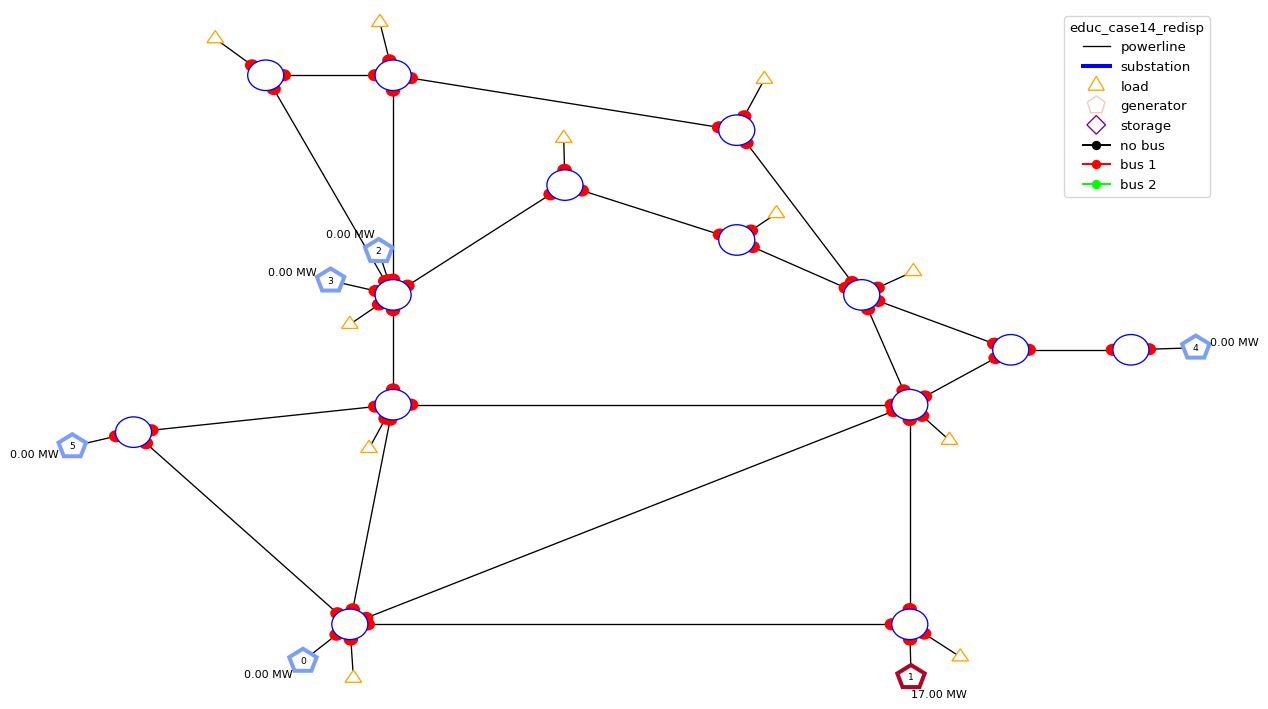

In [10]:
fig_ = plot_helper.plot_current_dispatch(new_obs2, do_plot_actual_dispatch=False)

##### third constraints: the pmin / pmax
Ok so now let's see a third (and last) type of physical constraints that are important for generators.

In reality, just like you cannot run at 50km.h^-1 or drive a bike at 200km.h^-1, or your car cannot drive at 600km.h^-1 or a plane cannot fly at 100.000km.h^-1, there are maximum values (and minimum) values a generator can produce.

Any attempt to go above pmax or bellow pmin will be "limited" by the environment. For example, if a generator is operated at pmax, and you ask to increase its production, then the action will not be implemented on the grid with the same mechanism detailed above.

### 5) Wrapping up

Congratulations, you just learn a new game based on a real industrial system !

This new "game" can be summarize as maintaining in safety a powergrid (see sections [Game over conditions](#Game-over-conditions) and [Operate in safety](#Operate-in-safety)) for a certain amount of time (in this environment a day) while using some actions consisting in "[Modifying the status of the powerlines](#Modifying-the-status-of-the-powerlines)" or performing "[Redispatching](#Redispatching)".

Your reward will be sum of the margin on the grid (see [Margin on a powerline](#Margin-on-a-powerline)). It is highest when the flows are minimal. It is 0.0 after a game for the rest of the scenarios and always positive. 

As any reinforcement learning setting, you need to maximise this reward.

Good luck !


### 6) Optional: diving deeper into grid2op
For this lecture it's probably not necessary to go into such details, but you might encounter some "hard to explain" behaviour when you building your first agent. 

#### Dataset
For this environment you have at your disposal a few scenarios each representing the equivalent of a day (24 hours) of grid operation at a 5 mins resolution. 

The datasets are located at:
```python
print(f"Data are located at {env.chronics_handler.path}")
```
And you can list what is in there

In [11]:
import os
all_days = sorted(os.listdir(env.chronics_handler.path))
all_days

['2019-01-12',
 '2019-01-13',
 '2019-01-14',
 '2019-01-15',
 '2019-01-16',
 '2019-01-17',
 '2019-01-18']

A grid2op typical dataset is made of scenarios. Each scenario has a name (in this case the name matches the day this scenario represents).

So for this environment you have 7 different days. For each day, a "grid dataset" is made (in this case) of 4 csv:
- "load_p.csv.bz2" represents the "active loads" (how much power people will consume at each steps)
- "prod_p.csv.bz2" represents the "active generation" (how much power powerplant will produce at each steps). Note that this represents their production in case there are no redispatching.

The other file are important for grid2op but are how of the scope of this notebook.

You can list them with the command below:

In [12]:
sorted(os.listdir(os.path.join(env.chronics_handler.path, all_days[0])))

['load_p.csv.bz2',
 'load_p_forecasted.csv.bz2',
 'load_q.csv.bz2',
 'load_q_forecasted.csv.bz2',
 'prod_p.csv.bz2',
 'prod_p_forecasted.csv.bz2',
 'prod_v.csv.bz2',
 'prod_v_forecasted.csv.bz2',
 'start_datetime.info',
 'time_interval.info']

#### Specific rules
One more thing that might be usefull.

In grid2op there are different kinds of rules that "model" some constraints the powergrid operators have to deal with in reality.

These "constraints" are similar to "rules" in video games. See the section [Random Agent and operational constraints](#Random-Agent-and-operational-constraints) for more information about some of them.

The main rules used for this environment are:

- **cooldown**: if you act on a powergrid, you have to wait a few number (3 in this case) of steps before you can act on the same powerline again
- **restoration time**: if a powerline is disconnected because of the "protections" (see section [Thermal limits and protections](#Thermal-limits-and-protections) ) you have to wait 12 steps before you can reconnect it. This model the fact that in reality you have to send some team of people to inspect that the powerline can be safely set back into service.

If an action would violate these rules, it is replaced by "do nothing" (see [Random Agent and operational constraints](#Random-Agent-and-operational-constraints) for a more detail explanation).


We remind also that the environment also takes into account some physical constraints:

Some powerline are disconnected when they are in overflow for too long, or when their overflow is too high (see section [Thermal limits and protections](#Thermal-limits-and-protections) ) and there is nothing the agent can do about that (beside of course reduce the flow on the concerned powerlines).

The redispatching implemented is not what the agent asked for. This is mainly due to the physical aspect of powergrids that are detailed in section [Redispatching](#Redispatching). 

## Creating some agents

Ok now we know all about the problems we want to solve in this environment. We recall that this problem is explained in more detail in the [5) Wrapping up](#5\)-Wrapping-up) section (with hyper text links pointing to most relevant questions if you have any interrogation or need a reminder.

### 1) Compatibility with gym
Grid2op is a framework fully compatible with openAI-gym. This means that there are the same interface (`env`, `env.step`, `env.reset`, `agent.act` etc.) but this does not entails that it is a gym environment. 

Actually, for people who don't know openAI gym (and this is the case of most people having a "power system" background) we did not want to include  more complexity to this problem.

However we put a lot of effort to make the use of grid2op with this framework as easy as possible.


#### Convert the environment to gym
To benefit from the openAI gym integration, the first thing you need to do is converting the grid2op environment to an open AI gym environment. In the next cell we show an example on how to do it. 

In [13]:
import gym
from grid2op.gym_compat import GymEnv
gym_env = GymEnv(env)
print(f"Is env and open AI gym environment: {isinstance(env, gym.Env)}")
print(f"Is gym_env and open AI gym environment: {isinstance(gym_env, gym.Env)}")

Is env and open AI gym environment: False
Is gym_env and open AI gym environment: False


**NB** some feature of grid2op are only available when the environment is presented as a grid2op environment and not as a gym environment. These exact features are out of the scope of this notebook.

#### Convert the observation space to gym

Stricly speaking, the observation space and the action space are now gym spaces. as is shown in the next figure.

There are of type `Dict` with the keys being the attribute present of the observation (or the action) and the values depends on the type of variable. It is often "Boxes" for floating pointing numbers (continuous variables, such as the flows on the powerline) and "MultiBinary" for discrete variable for example for the status (connected / disconnected) of the powerline.

The observation state, in this case is:

In [14]:
gym_env.observation_space

Dict('_shunt_bus': Box(-2147483648, 2147483647, (1,), int32), '_shunt_p': Box(-inf, inf, (1,), float32), '_shunt_q': Box(-inf, inf, (1,), float32), '_shunt_v': Box(-inf, inf, (1,), float32), 'a_ex': Box(0.0, inf, (20,), float32), 'a_or': Box(0.0, inf, (20,), float32), 'actual_dispatch': Box([-140. -120.  -70.  -70.  -40. -100.], [140. 120.  70.  70.  40. 100.], (6,), float32), 'attention_budget': Box(0.0, inf, (1,), float32), 'current_step': Box(-2147483648, 2147483647, (1,), int32), 'curtailment': Box(0.0, 1.0, (6,), float32), 'curtailment_limit': Box(0.0, 1.0, (6,), float32), 'curtailment_limit_effective': Box(0.0, 1.0, (6,), float32), 'day': Discrete(32), 'day_of_week': Discrete(8), 'delta_time': Box(0.0, inf, (1,), float32), 'duration_next_maintenance': Box(-1, 2147483647, (20,), int32), 'gen_margin_down': Box(0.0, [ 5. 10.  0.  0.  0. 15.], (6,), float32), 'gen_margin_up': Box(0.0, [ 5. 10.  0.  0.  0. 15.], (6,), float32), 'gen_p': Box(-162.01, [302.01    282.01    232.01001 232.

Ouf that is a lot of information, there are plenty of data available and we don't really know what to do with all that. Let's simplify it a bit and keep only some interesting component:

- `line_status`: that tells whether or not a powerline is connected or disconnected
- `rho`: which represents the flows, expressed in percentage of the thermal limit (see [Thermal limits and protections](#Thermal-limits-and-protections))
- `actual_dispatch`: which represents the current state of redispatching (see [Redispatching](#Redispatching))
- `target_dispatch`: the setpoint given by the agent until then

In [15]:
ob_space = gym_env.observation_space
ob_space = ob_space.keep_only_attr(("rho", "line_status", "actual_dispatch", "target_dispatch", "time_before_cooldown_line"))
gym_env.observation_space = ob_space
gym_env.observation_space

Dict('actual_dispatch': Box([-140. -120.  -70.  -70.  -40. -100.], [140. 120.  70.  70.  40. 100.], (6,), float32), 'line_status': MultiBinary(20), 'rho': Box(0.0, inf, (20,), float32), 'target_dispatch': Box([-140. -120.  -70.  -70.  -40. -100.], [140. 120.  70.  70.  40. 100.], (6,), float32), 'time_before_cooldown_line': Box(0, 12, (20,), int32))

In [16]:
ob_space.spaces.keys()

dict_keys(['actual_dispatch', 'line_status', 'rho', 'target_dispatch', 'time_before_cooldown_line'])

Much better now, isn't it ?

For example, let's sample an observation, to see what type of data an agent will receive:

In [17]:
gym_env.observation_space.sample()

{'actual_dispatch': array([-125.73364  ,   70.80158  ,  -32.93963  ,  -63.5015   ,
           4.4668837,  -65.824814 ], dtype=float32),
 'line_status': array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       dtype=int8),
 'rho': array([1.2933323 , 0.7289086 , 0.48578343, 0.25870574, 0.05990595,
        0.8325435 , 0.23067003, 0.509929  , 0.17381158, 0.9362833 ,
        0.2319882 , 0.4989118 , 3.0802386 , 0.278033  , 0.53932387,
        0.4679019 , 0.33966383, 0.20410189, 1.0021108 , 1.0444757 ],
       dtype=float32),
 'target_dispatch': array([ 58.509846, -52.012383, -55.38906 , -27.736835,  -5.218774,
        -77.31046 ], dtype=float32),
 'time_before_cooldown_line': array([ 6, 12,  8,  1,  3,  7,  2,  6,  9,  2,  9,  4, 11, 12, 11,  8,  1,
         3,  9, 12])}

Oh but we see here that the dispatch (sampled, remember that open AI gym by default don't take into account all the information given in part [Problem statement](#Problem-statement)) 

It's considered a good practice in generator to feed a neural network with data approximately in range [-1, 1]. Again, scaling the data in grid2op is relatively easy, and can be done the following way:

In [18]:
from grid2op.gym_compat import ScalerAttrConverter
ob_space = gym_env.observation_space
ob_space = ob_space.reencode_space("actual_dispatch", 
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env.gen_pmax,
                                                       init_space=ob_space["actual_dispatch"])
                                  )
ob_space = ob_space.reencode_space("target_dispatch",
                                   ScalerAttrConverter(substract=0.,
                                                       divide=env.gen_pmax,
                                                       init_space=ob_space["target_dispatch"])
                                  )
gym_env.observation_space = ob_space
gym_env.observation_space.sample()

{'actual_dispatch': array([ 0.9718044 , -0.02541745,  0.12804766, -0.03964331,  0.8858055 ,
        -0.5631172 ], dtype=float32),
 'line_status': array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       dtype=int8),
 'rho': array([0.7352537 , 2.4212015 , 0.24138054, 0.03126109, 1.9904157 ,
        0.66948414, 1.7009308 , 1.0305388 , 0.34465063, 3.1638546 ,
        0.83653206, 0.8296657 , 1.3401772 , 0.67610806, 0.8905948 ,
        0.16535696, 0.15620956, 0.52338356, 0.8274249 , 1.5588688 ],
       dtype=float32),
 'target_dispatch': array([-0.13436155,  0.03833117, -0.8432401 , -0.5535442 , -0.67795175,
        -0.9116966 ], dtype=float32),
 'time_before_cooldown_line': array([ 0,  0,  4,  8,  4, 10, 12,  6,  8,  1, 12,  2, 10,  1,  0,  5,  2,
         6,  5,  2])}

Much better now, all the variables are in range [-1, 1]. 

So to summarize what we did in this subpart:

- first we extracted some relevant information of the observation space
- then we noticed some values were out of a "normal" range so we rescale them

This way, the agent will only have access to relevant information (preventing overfitting for example) and it will be able to learn as efficiently as possible.

#### Convert the action space

As for the observation space, we will also try to convert the action space.

But first, let's see what it looks like:

In [19]:
act_space = gym_env.action_space
act_space

Dict('change_line_status': MultiBinary(20), 'redispatch': Box([ -5. -10.   0.   0.   0. -15.], [ 5. 10.  0.  0.  0. 15.], (6,), float32))

So we have to kind of actions:
- "*change_line_status*": if we want to change the status of a powerline (for example connect it if it is disconnected, or disconnect it if it's connected) cf. [Modifying the status of the powerlines](#Modifying-the-status-of-the-powerlines)
- "*redispatch*": if we want to apply redispatching actions cf. [Redispatching](#Redispatching)

Let's see how an action should look like:

In [20]:
act_space.sample()

{'change_line_status': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       dtype=int8),
 'redispatch': array([ 2.9583163, -7.0003386,  0.       ,  0.       ,  0.       ,
        14.559937 ], dtype=float32)}

The line status change is pretty straight forward: we put 1 when we want to toggle the status of the powerline and 0 other.

What might be a bit complicated here is the encoding of the redispatching. We have to pass a vector of floating point numberd and continuous actions are always more difficult than discrete actions. It this section we will encode this space so that, for each generator you will have 3 choices: 
- dispatch positively (increase the production of this generator)
- dispatch at all
- dispatch negatively (decrease the production of this generator)

To that end we will

In [21]:
from grid2op.gym_compat import ContinuousToDiscreteConverter
act_space = act_space.reencode_space("redispatch",
                                     ContinuousToDiscreteConverter(nb_bins=3,
                                                                   init_space=act_space["redispatch"])
                                    )
gym_env.action_space = act_space
act_space

Dict('change_line_status': MultiBinary(20), 'redispatch': MultiDiscrete([3 3 1 1 1 3]))

Ok great so now everything is discrete, which should be much better. Let's see how an action looks like:

In [22]:
act_space.sample()

{'change_line_status': array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0],
       dtype=int8),
 'redispatch': array([1, 1, 0, 0, 0, 2], dtype=int64)}

### 2) Some Baselines

#### Do nothing "agent"
The first baseline we can implement is the "do nothing" agent. This agent will simply .... do nothing, under any circumstances.

Let's see how it performs here by evaluating it on the first week (remember each episode represents a day, so to evaluate it on a full week we need to run it on 7 episodes).

In fact this agent is so simple that we will not even bother writing a class for it :-)

In [23]:
nb_day = 1 # put 7 for a "real test" we put 1 to increase speed during tests
from tqdm.notebook import tqdm  # for better progress bars

# build the do nothing action
do_nothing_act = gym_env.action_space.sample()
do_nothing_act["change_line_status"][:] = 0  # i enforce the fact "i don't modify any line status"
do_nothing_act["redispatch"][:] = 1  # i enforce the fact "i don't modify any generators"

In [24]:
# run the episode
cum_reward = []
nb_ts_survived = []
for i in tqdm(range(nb_day)):
    obs = gym_env.reset()
    reward = gym_env.reward_range[0]
    done = False
    ts = 0
    tmp_cum_reward = 0.
    while not done:
        obs, reward, done, info = gym_env.step(do_nothing_act)
        ts += 1
        tmp_cum_reward += reward
        if max_iter != -1 and ts >= max_iter:
            break
    nb_ts_survived.append(ts)
    cum_reward.append(tmp_cum_reward)
print(f"Over the {nb_day} the do nothing agent survived on average {np.mean(nb_ts_survived):.2f} / 288 steps")
print(f"Its average reward is  {np.mean(cum_reward):.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

#### Random Agent and operational constraints
Now that we know how to do nothing, well kind of, let's build or first acting agent, an agent that takes random actions.

Before we do that, we need to explain some "operational constraints", that are similar to "rules" in video games.

A first rule is that you cannot change the status of more than 1 powerline at each step. This constraints comes from the fact that today humans operators are in command of the grid and humans are not known to multi task really well, especially when there are so much at stake. To reduce the possibility of errors, it is asked to one human to only do one thing at a time.

A second rule comes from the material. A breaker on a powergird do not exactly look like the switch on your house. A typical breaker can look like this:
![](./img/circuit_breaker.png)
*image credit*: https://www.globalspec.com/learnmore/electrical_electronic_components/electrical_distribution_protection_equipment/circuit_breakers

And well... who would want to operate this thing by turning it on and off again at the risk of breaking it ? No one really want that, this is why there is some "cooldown time". When you act on a breaker at a given step, you cannot act on it in the next 2 or 3 steps.


If you "break these rules", your action is replaced by "do nothing" automatically. This is exactly what happens in video games. If you face a wall, a "rule" prevent you to cross it (in most video games at least). And most of the time, if you try to "go forward" when facing this wall, your character will not move an inch. This is the same for the powergrid. If a wrong "command" is sent to the system, nothing is done at all.

Given that, let's see how we can do a random agent that meets this constraint.

In [25]:
class RandomAgentWithConstraints:
    def __init__(self, action_space):
        self.action_space = action_space
        self.do_nothing_act = action_space.sample()
        self.do_nothing_act["change_line_status"][:] = 0  # i enforce the fact "i don't modify any line status"
        self.do_nothing_act["redispatch"][:] = 1  # i enforce the fact "i don't modify any generators"
        
    def act(self, obs, reward, done):
        # generate a random action that do not meet the oeprationnal constraints
        res = self.action_space.sample()
        # select only one powerline among the powerline that are supposed to be disconnected
        # in the random action
        # and set the other one to 0
        ls = res["change_line_status"]
        if np.any(ls > 0):
            id_ = np.random.choice(np.where(ls)[0], 1)
            ls[:] = 0
            ls[id_] = 1
        return res

In [26]:
cum_reward_2 = []
nb_ts_survived_2 = []
random_with_const = RandomAgentWithConstraints(gym_env.action_space)
for i in tqdm(range(nb_day)):
    obs = gym_env.reset()
    reward = gym_env.reward_range[0]
    done = False
    ts = 0
    tmp_cum_reward = 0.
    while not done:
        action = random_with_const.act(obs, reward, done)
        obs, reward, done, info = gym_env.step(action)
        ts += 1
        tmp_cum_reward += reward
        if max_iter != -1 and ts >= max_iter:
            break
    nb_ts_survived_2.append(ts)
    cum_reward_2.append(tmp_cum_reward)
print(f"Over the {nb_day} the random agent survived on average {np.mean(nb_ts_survived_2):.2f} / {max_iter} steps")
print(f"Its average reward is  {np.mean(cum_reward_2):.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

As we can see, and this is pretty common in "real systems" (as opposed to video games) doing nothing is most of the time a good strategy: the "do nothing agent" survived on average 205 steps while an agent that takes random actions only surive 3-4 steps (depending on which random actions are taken)

This is mainly due to the disconnection of powerlines.


### 3) Going further

1. Try to implement an agent that only takes random redispatching action
2. Can you code an agent that reconnect powerlines when they are disconnected, and only then ?
3. Could you imagine a way to have a good performing agent ?